In [1]:
import os
os.chdir(os.pardir)

In [2]:
def _set_num_turbines_in_row(n_turbines, rotor_diameter=77, spacing=None, angle_deg=0):
    xcoords = []
    ycoords = []

    row_spacing = max(spacing, rotor_diameter * 3)

    dx = row_spacing * np.cos(np.radians(angle_deg))
    dy = row_spacing * np.sin(np.radians(angle_deg))
    x0 = 0
    y0 = 0

    for i in range(n_turbines):
        turb = Point((x0 + i * dx, y0 + i * dy))
        xcoords.append(turb.x)
        ycoords.append(turb.y)

    return xcoords, ycoords

def _single_year_to_multiyear_gen(gen, degradation, analysis_period):
    gen_profile = gen.Outputs.gen
    assert len(gen_profile) == 8760
    # --- apply degradation --- 
    years = []
    for y in range(0, int(analysis_period)):
        gen_year = np.array(gen_profile)
        gen_year = gen_year * ((1 - degradation) ** y)
        years.append(gen_year)

    # --- concatenate ---
    out = np.concatenate(years).ravel().tolist()
    return out

2020-10-08 15:12:21,662 [MainThread  ] [INFO ]  

2020-10-08 15:12:21,663 [MainThread  ] [INFO ]  Loading cambium data from pickle


44.53681244210238 7.887673835912737 9363419.447827604


Text(0, 0.5, 'Output MW')

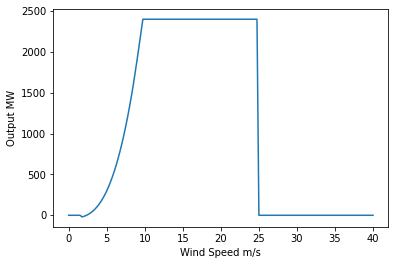

In [61]:
import numpy as np
import pandas as pd
from shapely.geometry import Point
pd.options.display.max_rows = 999

import PySAM.Windbos as wbos
import PySAM.Pvsamv1 as pvs
import PySAM.Pvwattsv7 as pvw
import PySAM.Battwatts as batt
import PySAM.Windpower as wp
import PySAM.StandAloneBattery as stbatt
import PySAM.Grid as gr
import PySAM.Utilityrate5 as ur
import PySAM.Cashloan as cl
import PySAM.Merchantplant as mp
from PySAM.BatteryTools import size_li_ion_battery, battery_model_sizing

import vapor
import vapor.config as config

load = vapor.BuildingLoad()
load.load()

resource_fp = 'data/PySAM Downloaded Weather Files/-87.031_42.192_psm3_60_tmy.csv'
cambium_df = vapor.datafetcher.load_cambium_data(aggregate_region='inter', scenario='StdScen19_Mid_Case')


wind_class_dict = {
    1:{'cut_in':9.01, 'cut_out':12.89},
    2:{'cut_in':8.77, 'cut_out':9.01},
    3:{'cut_in':8.57, 'cut_out':8.77},
    4:{'cut_in':8.35, 'cut_out':8.57},
    5:{'cut_in':8.07, 'cut_out':8.35},
    6:{'cut_in':7.62, 'cut_out':8.07},
    7:{'cut_in':7.1, 'cut_out':7.62},
    8:{'cut_in':6.53, 'cut_out':7.1},
    9:{'cut_in':5.9, 'cut_out':6.53},
    10:{'cut_in':1.72, 'cut_out':5.9},
}

desired_system_capacity = 2400
turbine_height = 50
turbine_class = 10

gen = wp.default('WindPowerSingleOwner') #Resource, Turbine, Farm, Losses, Uncertainty, AdjustmentFactors
gen.Resource.wind_resource_filename = 'data/PySAM Downloaded Weather Files/-99.347_30.927_wtk_60_2012.srw'
gen.Resource.wind_resource_model_choice = 0
# gen.Resource.weibull_reference_height = 50
# gen.Resource.weibull_k_factor = 2
# gen.Resource.weibull_wind_speed = 7.25

# gen.Turbine.wind_turbine_powercurve_windspeeds =[ 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75, 6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8, 8.25, 8.5, 8.75, 9, 9.25, 9.5, 9.75, 10, 10.25, 10.5, 10.75, 11, 11.25, 11.5, 11.75, 12, 12.25, 12.5, 12.75, 13, 13.25, 13.5, 13.75, 14, 14.25, 14.5, 14.75, 15, 15.25, 15.5, 15.75, 16, 16.25, 16.5, 16.75, 17, 17.25, 17.5, 17.75, 18, 18.25, 18.5, 18.75, 19, 19.25, 19.5, 19.75, 20, 20.25, 20.5, 20.75, 21, 21.25, 21.5, 21.75, 22, 22.25, 22.5, 22.75, 23, 23.25, 23.5, 23.75, 24, 24.25, 24.5, 24.75, 25, 25.25, 25.5, 25.75, 26, 26.25, 26.5, 26.75, 27, 27.25, 27.5, 27.75, 28, 28.25, 28.5, 28.75, 29, 29.25, 29.5, 29.75, 30, 30.25, 30.5, 30.75, 31, 31.25, 31.5, 31.75, 32, 32.25, 32.5, 32.75, 33, 33.25, 33.5, 33.75, 34, 34.25, 34.5, 34.75, 35, 35.25, 35.5, 35.75, 36, 36.25, 36.5, 36.75, 37, 37.25, 37.5, 37.75, 38, 38.25, 38.5, 38.75, 39, 39.25, 39.5, 39.75, 40 ];
# gen.Turbine.wind_turbine_powercurve_powerout =[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21.32, 33.509999999999998, 45.689999999999998, 65.209999999999994, 79.829999999999998, 104.25, 128.66, 157.97, 187.27000000000001, 216.58000000000001, 250.78, 292.31999999999999, 333.85000000000002, 375.39999999999998, 426.72000000000003, 475.60000000000002, 534.26999999999998, 597.80999999999995, 656.49000000000001, 724.94000000000005, 798.28999999999996, 871.63, 940.08000000000004, 1010, 1060, 1130, 1190, 1240, 1290, 1330, 1370, 1390, 1410, 1430, 1440, 1460, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]

powercurve_dict = {
    'turbine_size':2400,
    'rotor_diameter':116,
    'elevation':0,
    'max_cp':0.45,
    'max_tip_speed':116,
    'max_tip_sp_ratio':8,
    'cut_in':wind_class_dict[turbine_class]['cut_in'],
    'cut_out':25, #not sure how to interpret maximum wind speeds, as they are too low for sensible cutout
    'drive_train':0,
}

gen.Turbine.calculate_powercurve(**powercurve_dict)

gen.Turbine.wind_resource_shear = 0.14
gen.Turbine.wind_turbine_rotor_diameter = 116
# gen.Turbine.wind_turbine_max_cp = 0.45
gen.Farm.wind_farm_wake_model = 0
gen.Farm.wind_resource_turbulence_coeff = 0.1
turbine_kw = max(gen.Turbine.wind_turbine_powercurve_powerout)
n_turbines = int(desired_system_capacity // turbine_kw)
gen.Farm.system_capacity = turbine_kw * n_turbines
xcoords, ycoords = _set_num_turbines_in_row(n_turbines=n_turbines, spacing=250)
gen.Farm.wind_farm_xCoordinates = xcoords
gen.Farm.wind_farm_yCoordinates = ycoords
gen.Losses.wake_int_loss = 0
gen.Losses.wake_ext_loss = 1.1
gen.Losses.wake_future_loss = 0
gen.Losses.avail_bop_loss = 0.5
gen.Losses.avail_grid_loss = 1.5
gen.Losses.avail_turb_loss = 3.58
gen.Losses.elec_eff_loss = 1.91
gen.Losses.elec_parasitic_loss = 0.1
gen.Losses.env_degrad_loss = 1.8
gen.Losses.env_exposure_loss = 0
gen.Losses.env_env_loss = 0.4
gen.Losses.env_icing_loss = 0.21
gen.Losses.ops_env_loss = 1
gen.Losses.ops_grid_loss = 0.84
gen.Losses.ops_load_loss = 0.99
gen.Losses.ops_strategies_loss = 0
gen.Losses.turb_generic_loss = 1.7
gen.Losses.turb_hysteresis_loss = 0.4
gen.Losses.turb_perf_loss = 1.1
gen.Losses.turb_specific_loss = 0.81
gen.Uncertainty.total_uncert = 12.085
gen.execute()

print(gen.Outputs.capacity_factor, gen.Outputs.wind_speed_average, gen.Outputs.annual_energy)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(gen.Turbine.wind_turbine_powercurve_windspeeds, gen.Turbine.wind_turbine_powercurve_powerout)
ax.set_xlabel('Wind Speed m/s')
ax.set_ylabel('Output MW')

In [ ]:
# for taller towers, add 6.383 per kW per M, default of 80. 
# expose wind speed class as 1-10 bounded parameter? 